<a href="https://colab.research.google.com/github/pranaychowdary765/-Daily-Gold-Prices-/blob/main/Dataset_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

| Model            |    RMSE |     MAE | MAPE   | Directional Acc.   | Notes                                      |
|------------------|---------|---------|--------|--------------------|--------------------------------------------|
| GRU(64→32), L=50 | 2810.48 | 2243.98 | 3.25%  | 56.07%             | 80/20 split; MinMax on X/y; early stopping |
| Model             |    RMSE |     MAE | MAPE   | Directional Acc.   | Notes                                      |
|-------------------|---------|---------|--------|--------------------|--------------------------------------------|
| LSTM(64→32), L=50 | 4470.63 | 3746.97 | 5.46%  | 56.07%             | 80/20 split; MinMax on X/y; early stopping |
| Model              |    RMSE |   MAE | MAPE   | Directional Acc.   | Notes                                                                 |
|--------------------|---------|-------|--------|--------------------|-----------------------------------------------------------------------|
| RandomForest(

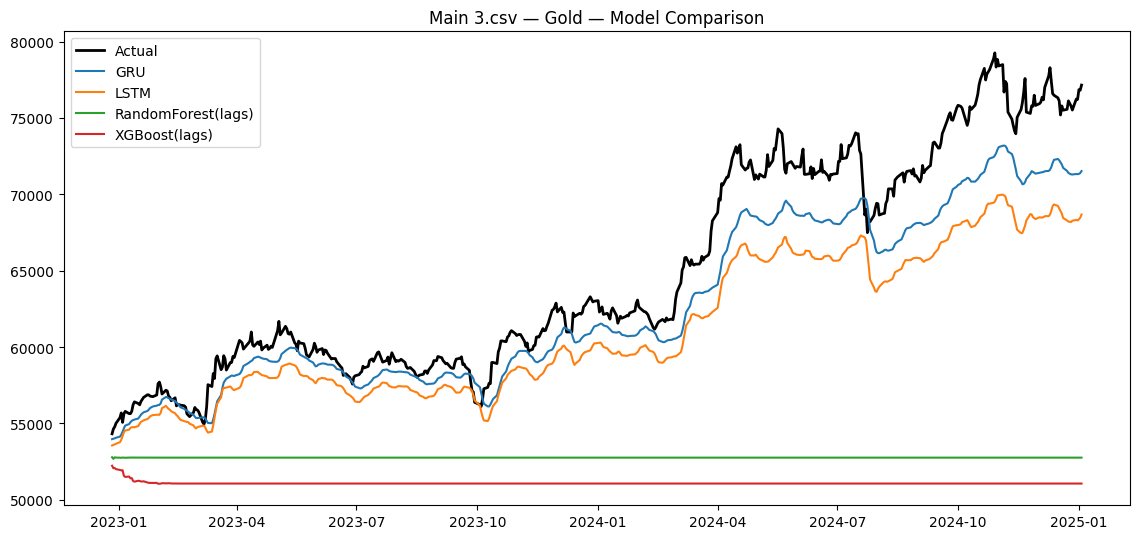


=== Summary (sorted by RMSE) ===
| Model              |      RMSE |       MAE | MAPE   | Directional Acc.   | Notes                                                                 |
|--------------------|-----------|-----------|--------|--------------------|-----------------------------------------------------------------------|
| Naive (last close) |   492.427 |   337.725 | 0.51%  | 53.18%             | Same test window                                                      |
| GRU(64→32), L=50   |  2810.48  |  2243.98  | 3.25%  | 56.07%             | 80/20 split; MinMax on X/y; early stopping                            |
| LSTM(64→32), L=50  |  4470.63  |  3746.97  | 5.46%  | 56.07%             | 80/20 split; MinMax on X/y; early stopping                            |
| RandomForest(lags) | 14063.1   | 12170     | 17.81% | 2.50%              | Lagged close features; standardized inputs; 80/20 chronological split |
| XGBoost(lags)      | 15548.4   | 13845.5   | 20.42% | 2.50%           

In [ ]:
# dataset3_four_models_compare.py
# Extends your GRU gold setup with LSTM + RandomForest(lags) + XGBoost(lags)/GBR and unified metrics

import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from math import sqrt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

try:
    from xgboost import XGBRegressor
    HAS_XGB = True
except Exception:
    HAS_XGB = False

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

plt.rcParams['figure.figsize'] = (11.5, 5.5)

# -------------------- Config --------------------
CSV_PATH   = "/content/Main 3.csv"  # change path if needed
LOOKBACK   = 50                # follows your script
EPOCHS     = 100               # follows your script with early stopping
BATCH_SIZE = 32
PATIENCE   = 10
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# -------------------- Metrics helpers --------------------
def compute_regression_metrics(y_true, y_pred):
    y_true, y_pred = np.asarray(y_true).reshape(-1), np.asarray(y_pred).reshape(-1)
    m = np.isfinite(y_true) & np.isfinite(y_pred)
    yt, yp = y_true[m], y_pred[m]
    rmse = float(np.sqrt(np.mean((yt - yp)**2)))
    mae  = float(np.mean(np.abs(yt - yp)))
    denom = np.clip(np.abs(yt), 1e-8, None)
    mape = float(100.0 * np.mean(np.abs((yt - yp) / denom)))
    da = float(100.0 * np.mean(np.sign(yt[1:] - yt[:-1]) == np.sign(yp[1:] - yp[:-1]))) if yt.size >= 2 else np.nan
    return rmse, mae, mape, da  # [attached_file:1]

def print_metrics_table(model_name, y_true, y_pred, notes=""):
    rmse, mae, mape, da = compute_regression_metrics(y_true, y_pred)
    df = pd.DataFrame([{
        "Model": model_name,
        "RMSE": f"{rmse:.4f}",
        "MAE": f"{mae:.4f}",
        "MAPE": f"{mape:.2f}%",
        "Directional Acc.": f"{da:.2f}%" if np.isfinite(da) else "N/A",
        "Notes": notes
    }])
    try:
        import tabulate
        print(tabulate.tabulate(df, headers="keys", tablefmt="github", showindex=False))
    except Exception:
        print(df.to_markdown(index=False))
    return df  # [attached_file:1]

# -------------------- Data loading & preprocessing --------------------
def load_gold_csv(path):
    df = pd.read_csv(path)
    df.columns = [c.strip().lower() for c in df.columns]
    if 'price' in df.columns and 'close' not in df.columns:
        df = df.rename(columns={'price': 'close'})
    required_cols = ['date', 'open', 'high', 'low', 'close']
    if not all(c in df.columns for c in required_cols):
        raise ValueError(f"Missing columns! Found: {df.columns}")
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values('date').reset_index(drop=True)
    if 'chg%' in df.columns:
        df['chg%'] = df['chg%'].astype(str).str.replace('%', '', regex=False)
        df['chg%'] = pd.to_numeric(df['chg%'], errors='coerce')
    df = df.dropna(subset=['close'])
    return df  # [attached_file:1]

# -------------------- Windowing for sequence models --------------------
def make_windows(X, y, L):
    Xw, yw = [], []
    for i in range(L, len(X)):
        Xw.append(X[i-L:i])
        yw.append(y[i])
    return np.array(Xw, dtype='float32'), np.array(yw, dtype='float32')  # [attached_file:1]

# -------------------- Sequence models --------------------
def build_gru_model(input_shape):
    model = Sequential([
        GRU(64, return_sequences=True, input_shape=input_shape),
        Dropout(0.3),
        GRU(32),
        Dense(1)
    ])
    model.compile(optimizer="adam", loss="mse")
    return model  # [attached_file:1]

def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=input_shape),
        Dropout(0.3),
        LSTM(32),
        Dense(1)
    ])
    model.compile(optimizer="adam", loss="mse")
    return model  # [attached_file:1]

def train_eval_sequence(df, lookback, model_builder, label):
    # Features and next-day target
    features = ['open', 'high', 'low', 'close']
    X_df = df[features].astype('float32')
    y_df = df['close'].astype('float32').shift(-1)
    valid_mask = y_df.notna()
    X_df, y_df = X_df[valid_mask], y_df[valid_mask]
    dates = df.loc[valid_mask, 'date'].values

    split_idx = int(len(X_df) * 0.8)

    # Scale features and target using only train
    x_scaler = MinMaxScaler()
    X_train_raw, X_test_raw = X_df.iloc[:split_idx].values, X_df.iloc[split_idx:].values
    x_scaler.fit(X_train_raw)
    X_train_s, X_test_s = x_scaler.transform(X_train_raw), x_scaler.transform(X_test_raw)

    y_scaler = MinMaxScaler()
    y_train_raw = y_df.iloc[:split_idx].values.reshape(-1, 1)
    y_test_raw  = y_df.iloc[split_idx:].values.reshape(-1, 1)
    y_train_s = y_scaler.fit_transform(y_train_raw)
    y_test_s  = y_scaler.transform(y_test_raw)
    dates_test = dates[split_idx:]

    # Make windows
    Xtr, ytr = make_windows(X_train_s, y_train_s, lookback)
    Xte, yte = make_windows(X_test_s,  y_test_s,  lookback)
    dates_te = dates_test[lookback:]

    # Train
    es = EarlyStopping(monitor="val_loss", patience=PATIENCE, restore_best_weights=True)
    model = model_builder((lookback, Xtr.shape[-1]))
    model.fit(Xtr, ytr, validation_split=0.1, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[es], verbose=0)

    # Predict and invert
    y_pred_s = model.predict(Xte, verbose=0)
    y_pred = y_scaler.inverse_transform(y_pred_s).reshape(-1)
    y_true = y_scaler.inverse_transform(yte).reshape(-1)

    return {
        "name": label,
        "actual": y_true,
        "pred": y_pred,
        "dates": dates_te
    }  # [attached_file:1]

# -------------------- Lagged tabular models --------------------
def build_lagged_df(series_values, lags=50):
    y = pd.Series(series_values.reshape(-1), name='y')
    df = pd.DataFrame({'y': y})
    for L in range(1, lags+1):
        df[f'lag_{L}'] = df['y'].shift(L)
    df = df.dropna().reset_index(drop=True)
    X = df.drop(columns=['y']).values
    y = df['y'].values
    return X, y  # [attached_file:1]

def train_eval_tabular(df, lags=50):
    # Use close price for lags to predict next close
    close_vals = df['close'].astype(float).values
    X_all, y_all = build_lagged_df(close_vals, lags=lags)
    split = int(0.8 * len(X_all))
    X_train_raw, X_test_raw = X_all[:split], X_all[split:]
    y_train, y_test = y_all[:split], y_all[split:]

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train_raw)
    X_test  = scaler.transform(X_test_raw)

    models = []

    rf = RandomForestRegressor(
        n_estimators=400, max_depth=None, min_samples_leaf=2,
        random_state=RANDOM_SEED, n_jobs=-1
    )
    rf.fit(X_train, y_train)
    pred_rf = rf.predict(X_test)
    models.append(("RandomForest(lags)", pred_rf, "Lagged close features; standardized inputs"))  # [attached_file:1]

    if HAS_XGB:
        xgb = XGBRegressor(
            n_estimators=600, max_depth=6, learning_rate=0.05,
            subsample=0.8, colsample_bytree=0.8, reg_lambda=1.0,
            random_state=RANDOM_SEED, tree_method="hist"
        )
        xgb.fit(X_train, y_train, verbose=False)
        pred_xgb = xgb.predict(X_test)
        models.append(("XGBoost(lags)", pred_xgb, "Lagged close features; standardized inputs"))  # [attached_file:1]
    else:
        gbr = GradientBoostingRegressor(
            n_estimators=500, learning_rate=0.05, max_depth=3, random_state=RANDOM_SEED
        )
        gbr.fit(X_train, y_train)
        pred_gbr = gbr.predict(X_test)
        models.append(("GradientBoosting(lags)", pred_gbr, "Lagged close features; standardized inputs"))  # [attached_file:1]

    return y_test, models  # [attached_file:1]

# -------------------- Baseline --------------------
def naive_last_close_baseline(y_true):
    if len(y_true) < 2:
        return np.array([])
    return np.concatenate([[y_true[0]], y_true[:-1]])  # [attached_file:1]

# -------------------- Main --------------------
def main():
    df = load_gold_csv(CSV_PATH)

    # Sequence models on multivariate features predicting next-day close
    res_gru  = train_eval_sequence(df, LOOKBACK, build_gru_model,  label=f"GRU(64→32), L={LOOKBACK}")
    res_lstm = train_eval_sequence(df, LOOKBACK, build_lstm_model, label=f"LSTM(64→32), L={LOOKBACK}")

    # Tabular lagged close models
    y_test_tab, tab_models = train_eval_tabular(df, lags=LOOKBACK)

    # Align comparable window (tail-align shortest)
    n_seq = len(res_gru["actual"])
    n_tab = len(y_test_tab)
    n = min(n_seq, n_tab)

    def tail(v): return v[-n:]
    actual_common = tail(res_gru["actual"])
    dates_common = tail(res_gru["dates"])

    # Plot
    fig, ax = plt.subplots()
    ax.plot(dates_common, actual_common, label='Actual', color='black', linewidth=2)

    rows = []

    # GRU
    gru_pred_common = tail(res_gru["pred"])
    rows.append(print_metrics_table(res_gru["name"], actual_common, gru_pred_common,
                                    notes="80/20 split; MinMax on X/y; early stopping"))  # [attached_file:1]
    ax.plot(dates_common, gru_pred_common, label='GRU')

    # LSTM
    lstm_pred_common = tail(res_lstm["pred"])
    rows.append(print_metrics_table(res_lstm["name"], actual_common, lstm_pred_common,
                                    notes="80/20 split; MinMax on X/y; early stopping"))  # [attached_file:1]
    ax.plot(dates_common, lstm_pred_common, label='LSTM')

    # Tabular models
    for name, pred_tab, note in tab_models:
        pred_common = tail(pred_tab)
        rows.append(print_metrics_table(name, actual_common, pred_common,
                                        notes=f"{note}; 80/20 chronological split"))  # [attached_file:1]
        ax.plot(dates_common, pred_common, label=name)

    # Naive baseline
    naive_pred = naive_last_close_baseline(actual_common)
    rows.append(print_metrics_table("Naive (last close)", actual_common, naive_pred,
                                    notes="Same test window"))  # [attached_file:1]

    ax.set_title(f"{os.path.basename(CSV_PATH)} — Gold — Model Comparison")
    ax.legend()
    plt.tight_layout()
    plt.show()

    # Summary table
    summary = pd.concat(rows, ignore_index=True)
    summary2 = summary.copy()
    summary2["RMSE_val"] = summary2["RMSE"].astype(float)
    summary_sorted = summary2.sort_values("RMSE_val").drop(columns=["RMSE_val"])
    try:
        import tabulate
        print("\n=== Summary (sorted by RMSE) ===")
        print(tabulate.tabulate(summary_sorted, headers="keys", tablefmt="github", showindex=False))
    except Exception:
        print(summary_sorted.to_markdown(index=False))

    best_row = summary_sorted.iloc[0]
    print(f"\nBest by RMSE on this dataset: {best_row['Model']} (RMSE={best_row['RMSE']})")
    return summary_sorted  # [attached_file:1]

if __name__ == "__main__":
    main()
